## Credit Card Fraud Detection

The dataset for this use case is here - https://www.kaggle.com/datasets/kartik2112/fraud-detection

This is a simulated data using this simulation tool -  https://github.com/namebrandon/Sparkov_Data_Generation

### About the Dataset

This is a simulated credit card transaction dataset containing legitimate and fraud transactions from the duration 1st Jan 2019 - 31st Dec 2020. It covers credit cards of 1000 customers doing transactions with a pool of 800 merchants.


### Business Requirements
Bank is looking for a way to identify a credit card transaction is fraud or not. This will save bank a lot of money and resources. Build a model which will classify the transaction as fraud or not  with  minimal cost.

A model should classify with a score of more than **80%**.




In [236]:
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import datetime
import time
from sklearn.exceptions import ConvergenceWarning

# import data processing libraries
from sklearn.preprocessing import OrdinalEncoder,LabelEncoder,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from category_encoders import TargetEncoder,JamesSteinEncoder

from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score,StratifiedKFold,RandomizedSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay,roc_curve,roc_auc_score,classification_report,balanced_accuracy_score,precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier,AdaBoostClassifier,BaggingClassifier
from sklearn import tree


# import models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB

# balance the dataset
from sklearn.utils import resample
from imblearn.over_sampling import RandomOverSampler,KMeansSMOTE,ADASYN,BorderlineSMOTE,SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier

#import keras for deep neural networks models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,InputLayer
from scikeras.wrappers import KerasClassifier
from keras.layers import Activation
from keras.regularizers import l2
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

from keras import losses

from sklearn_evaluation import plot
import graphviz
from keras_visualizer import visualizer


import warnings
warnings.filterwarnings('ignore')

from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore',category=ConvergenceWarning)
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses
    
ConvergenceWarning('ignore')

#intel sklearn extensions
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


### Introduction
We have 2 datasets one for training and the other one for testing the model. Lets load training dataset and do data analysis and model building on it.
The datasets are
* [Train Set](data/fraudTrain.csv)
* [Test Set](data/fraudTest.csv)

Lets use train set to evaluate models and figure out the best model then validate that model using test dataset once the model is trained with train set.

### Dataset


In [2]:
card_transaction_df = pd.read_csv('data/fraudTrain.csv')
card_transaction_df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


### Data Understanding

In [3]:
card_transaction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

This dataset contains 1.3M rows with  22 features. The dataset contains object,float and int type features.

In [4]:
card_transaction_df.duplicated().sum()

0

This dataset doesnt contains any duplicated rows to remove.

In [5]:
card_transaction_df.isnull().sum()

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

This dataset also doesnt contains any nulls so we dont have to impute any features.

In [6]:
card_transaction_df.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,Unnamed: 0,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1.29668e+06,1.29668e+06,1.29668e+06,1.29668e+06,1.29668e+06,1.29668e+06,1.29668e+06,1.29668e+06,1.29668e+06,1.29668e+06,1.29668e+06
mean,648337,4.17192e+17,70.351,48800.7,38.5376,-90.2263,88824.4,1.34924e+09,38.5373,-90.2265,0.00578865
std,374318,1.30881e+18,160.316,26893.2,5.07581,13.7591,301956,1.28413e+07,5.10979,13.7711,0.0758627
min,0,6.04162e+10,1,1257,20.0271,-165.672,23,1.32538e+09,19.0278,-166.671,0
25%,324168,1.80043e+14,9.65,26237,34.6205,-96.798,743,1.33875e+09,34.7336,-96.8973,0
50%,648337,3.52142e+15,47.52,48174,39.3543,-87.4769,2456,1.34925e+09,39.3657,-87.4384,0
75%,972506,4.64226e+15,83.14,72042,41.9404,-80.158,20328,1.35939e+09,41.9572,-80.2368,0
max,1.29667e+06,4.99235e+18,28948.9,99783,66.6933,-67.9503,2.9067e+06,1.37182e+09,67.5103,-66.9509,1


In this dataset, the minimum transaction amount is $1 and the maximum is $28948.

In [7]:
card_transaction_df['is_fraud'].value_counts()

0    1289169
1       7506
Name: is_fraud, dtype: int64

This dataset has around 7500 fraud transactions and 1.28M non-fraud transactions which is 0.5% of the dataset.

### Data Analysis
Lets do some data analysis to understand how these features are related and what story they tell us.

#### Univariate Analysis

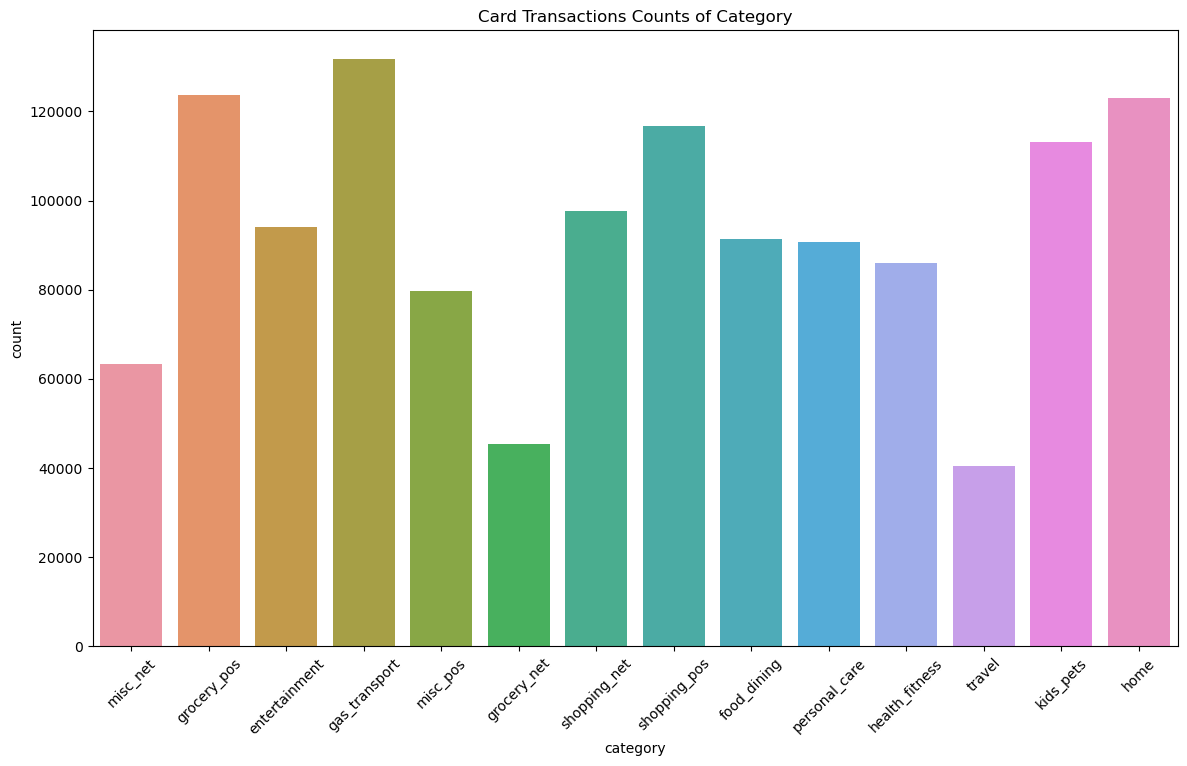

In [8]:
plt.figure(figsize=(14,8))
sns.countplot(card_transaction_df,x='category')
plt.xticks(rotation=45)
plt.title('Card Transactions Counts of Category')
plt.show()

Grocery, gas and home related transactions are hit with fraud a lot than other categories.

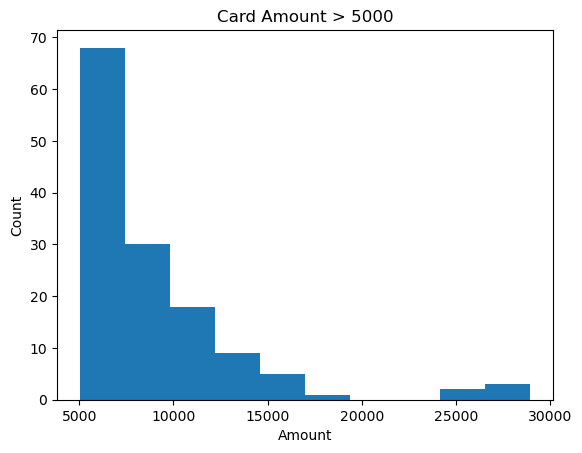

In [9]:
plt.title('Card Amount > 5000')
plt.hist(card_transaction_df.query("amt > 5000" )['amt'])
plt.xlabel('Amount')
plt.ylabel('Count')
plt.show()

The above plot shows that the transaction amount distribution of amount > $5000. And the below plots shows the other range of amount > 1000 and < 5000 , < 1000.

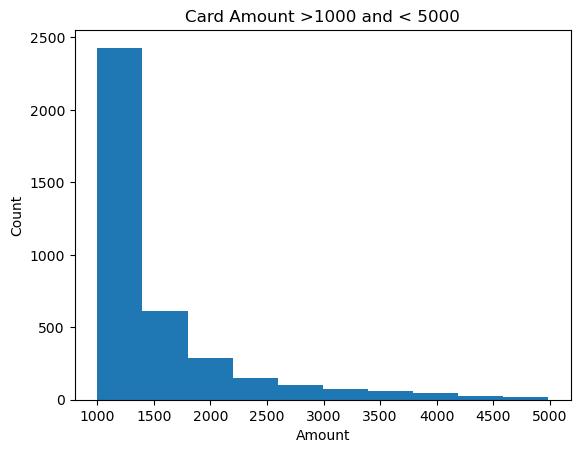

In [10]:
plt.title('Card Amount >1000 and < 5000')
plt.hist(card_transaction_df.query("amt < 5000 and amt > 1000" )['amt'])
plt.xlabel('Amount')
plt.ylabel('Count')
plt.show()

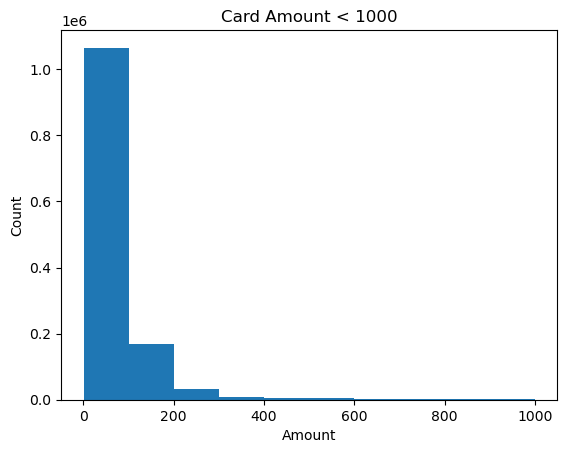

In [11]:
plt.title('Card Amount < 1000')
plt.hist(card_transaction_df.query("amt < 1000" )['amt'])
plt.xlabel('Amount')
plt.ylabel('Count')
plt.show()

It seems a lot of transactions are in the amount < $1000 only.

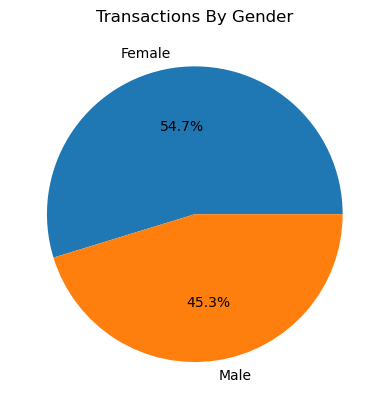

In [12]:
plt.title('Transactions By Gender')
plt.pie(card_transaction_df['gender'].value_counts(),labels=['Female','Male'],autopct='%1.1f%%')
plt.show()

This dataset has almost even distribution of gender with male and female.

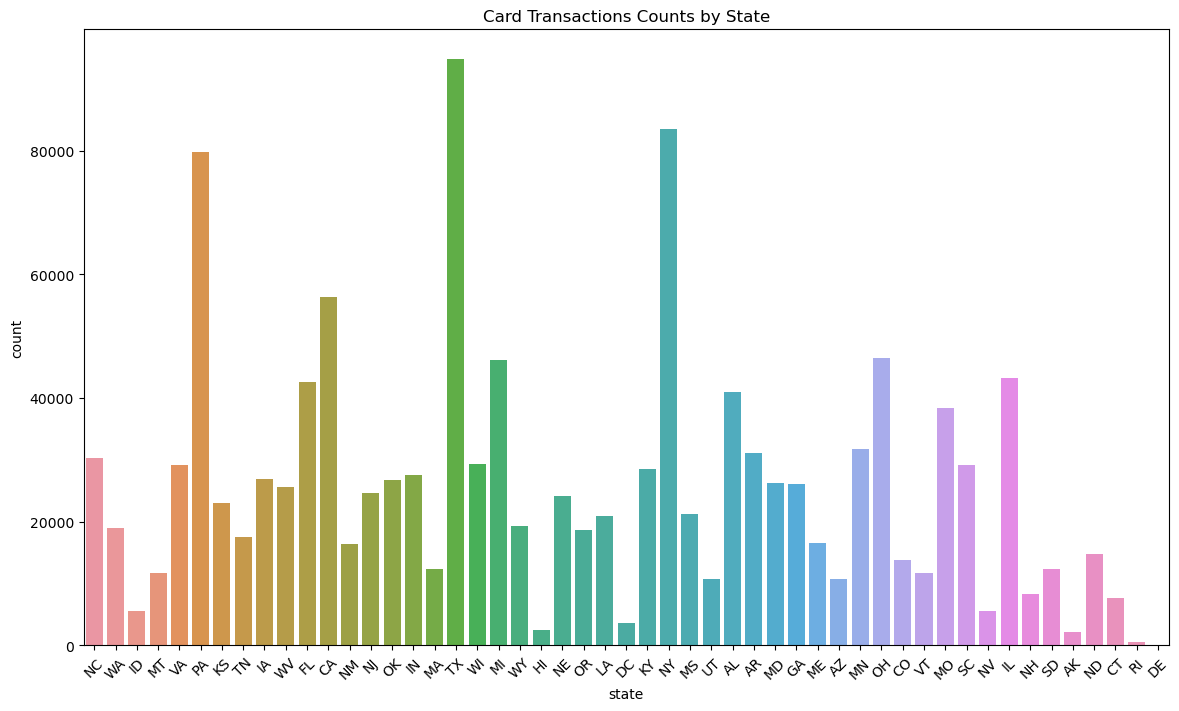

In [13]:
plt.figure(figsize=(14,8))
sns.countplot(card_transaction_df,x='state')
plt.xticks(rotation=45)
plt.title('Card Transactions Counts by State')
plt.show()

It seems PA,TX and NY states are having more transactions than other states.

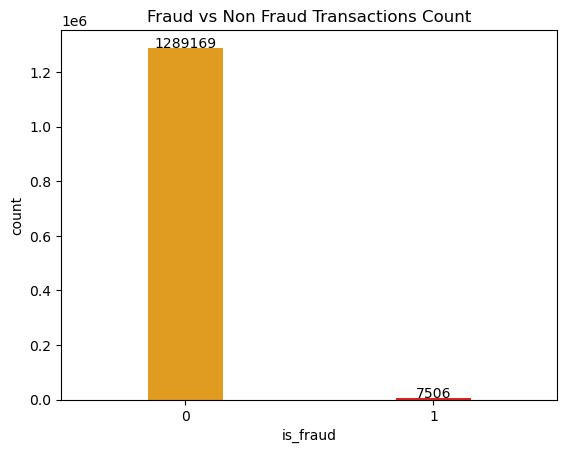

In [14]:
plot = sns.countplot(card_transaction_df,x='is_fraud',width=0.3,palette=['orange',"red"])
plot.text(0,len(card_transaction_df.query("is_fraud == 0")),len(card_transaction_df.query("is_fraud == 0")),horizontalalignment='center')
plot.text(1,len(card_transaction_df.query("is_fraud == 1")),len(card_transaction_df.query("is_fraud == 1")),horizontalalignment='center')
plt.title('Fraud vs Non Fraud Transactions Count')
plt.show()

In the dataset of 1.2M records there are only 7500 are fraud transactions.

#### Multivariate Analysis
Lets do some more analysis comparing with multiple features

<Figure size 1800x800 with 0 Axes>

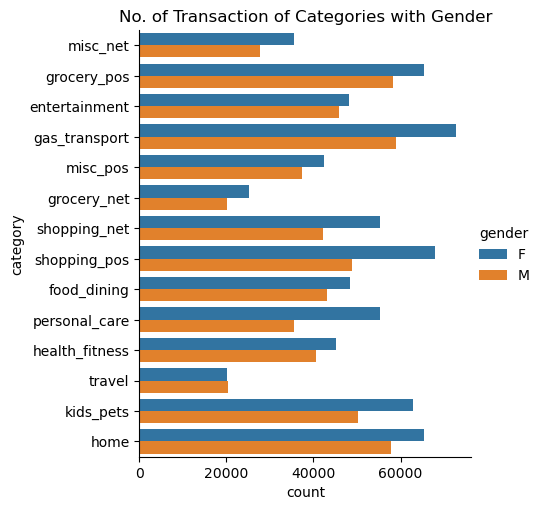

In [15]:
plt.figure(figsize=(18,8))
sns.catplot(data=card_transaction_df,y='category',kind='count',hue='gender')
plt.title('No. of Transaction of Categories with Gender')
plt.show()

The above plot shows that male and female are doing transactions more or less same in all categories.

In [16]:
# create a fraud transactions dataframe to analyze multivariate analysis
fraud_transactions_df = card_transaction_df.query("is_fraud == 1")

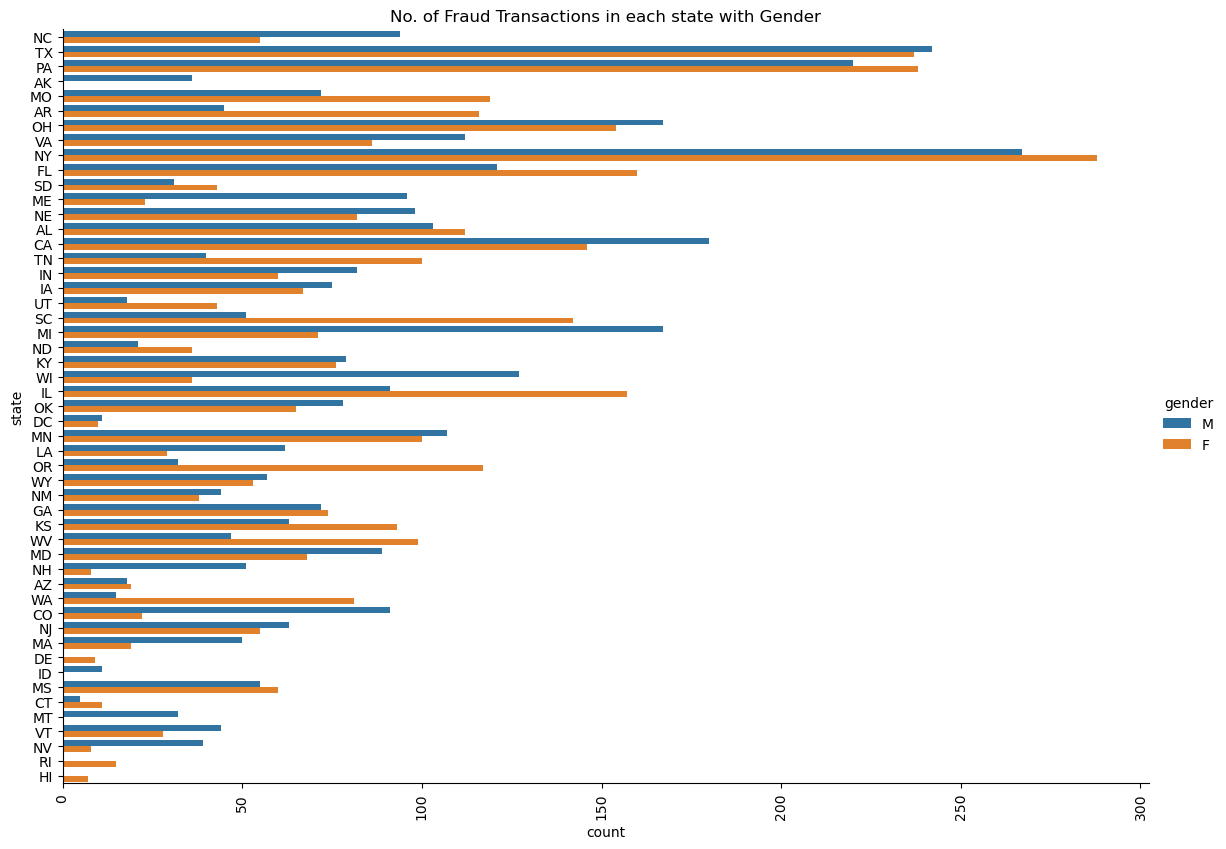

In [17]:
sns.catplot(data=fraud_transactions_df,y='state',kind='count',hue='gender',height=8.27, aspect=11.7/8.27)
plt.title('No. of Fraud Transactions in each state with Gender')
plt.xticks(rotation=90)
plt.show()

The above plot shows TX, PA and NY has a lot of fraud transactions than other states.

<Figure size 1800x800 with 0 Axes>

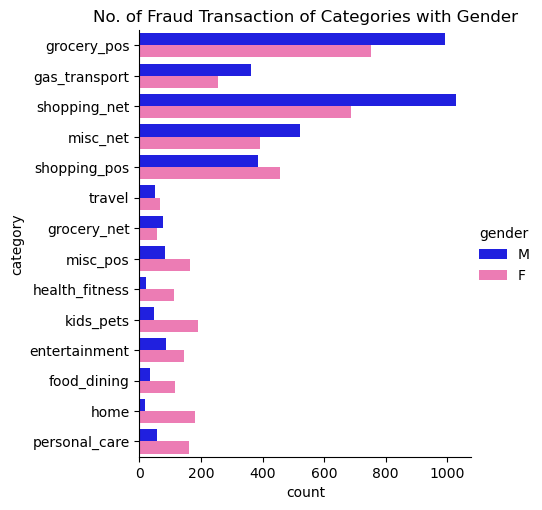

In [18]:
plt.figure(figsize=(18,8))
sns.catplot(data=fraud_transactions_df,y='category',kind='count',hue='gender',palette=['blue','hotpink'])
plt.title('No. of Fraud Transaction of Categories with Gender')
plt.show()

The above plot shows there are more fraud transactions groceries, internet shopping and general categories.

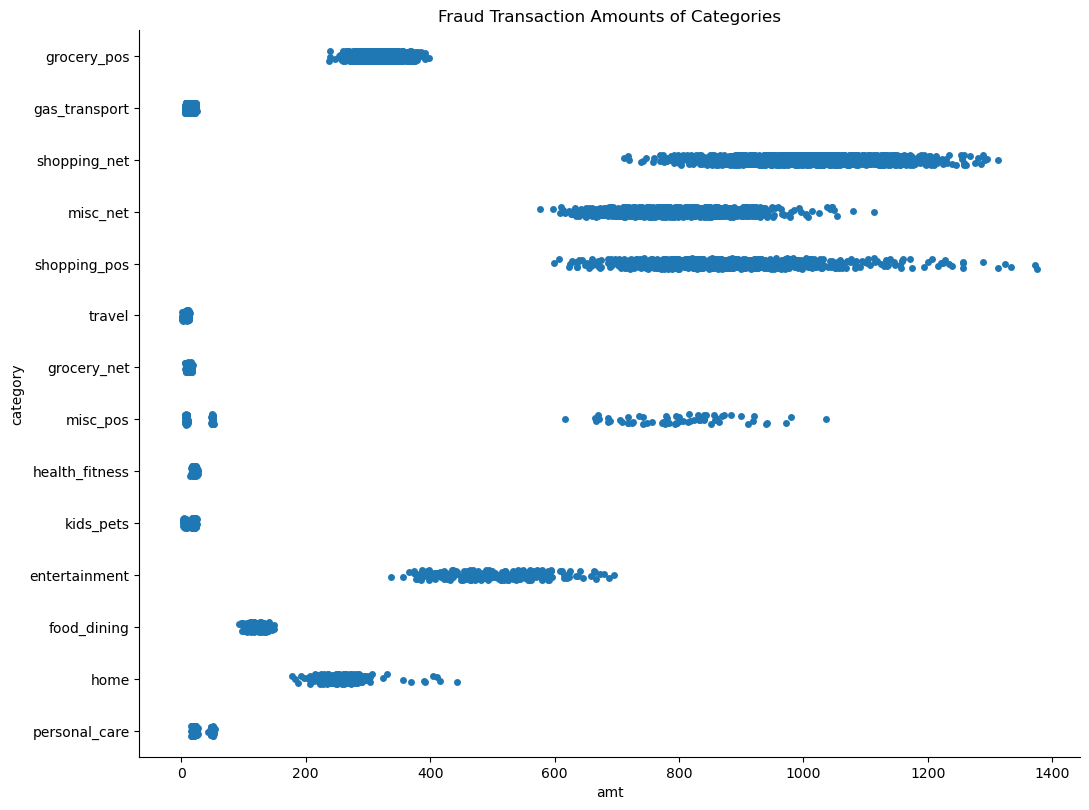

In [19]:
sns.catplot(data=fraud_transactions_df,y='category',x='amt',height=8, aspect=11/8)
plt.title('Fraud Transaction Amounts of Categories')
plt.show()

The above plot shows all of the fraud transactions with amount less than 1400 only.

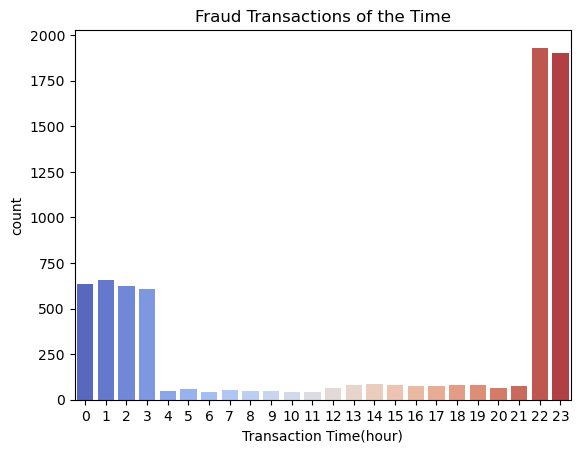

In [20]:
# convert the transaction date time into buckets of the day

sns.countplot(data=fraud_transactions_df,x=pd.to_datetime(fraud_transactions_df['trans_date_trans_time'],format="%Y-%m-%d %H:%M:%S").dt.hour,
              palette="coolwarm").set_title('Fraud Transactions of the Time')
plt.xlabel('Transaction Time(hour)')
plt.show()

The above plot shows that the fraud transactions are happening during mid nigh times like in 22,23 hours of the day.

In [21]:

fig = px.scatter_mapbox(data_frame=fraud_transactions_df,hover_name='state',lat='lat',lon='long',zoom=3,
                        mapbox_style='open-street-map',text='state')
fig.update_layout(margin={'r':0,'l':0,'t':0,'b':0},title='Fraud Transactions Map Plot')
fig.show()

The above geo plot shows that there are fraud transactions in almost every state of the US.

### Feature Engineering
Lets cleanup the data from the dataset which are not really useful in model building, transform features, create new features, encoding categorical features etc ...

#### Drop columns
Lets drop columns which are not necessary help in classifying a transaction as fraud. The columns are 'Unnamed: 0','cc_num','trans_num','first','last','merchant','zip','city_pop','street','unix_time'.

In [22]:
#drop columns cc_num,trans_num, first and last as these columns may not add value in classifying a transaction as fraud.
cleaned_up_df = card_transaction_df.drop(columns=['Unnamed: 0','cc_num','trans_num','first','last','merchant','zip','city_pop','street','unix_time'],axis=1)

#### Adding Features

##### Add 'transaction_hour'
Lets add **transaction_hour** from the transaction date time as it seems lot of frauds are happening over night and with that we can infer accurately. And then drop the trans_date_trans_time column.

In [23]:
# adding 'Hour' column as it might help in frauds as many frauds are happening overnight.
cleaned_up_df['transaction_hour'] = pd.to_datetime(card_transaction_df['trans_date_trans_time'],format="%Y-%m-%d %H:%M:%S").dt.hour
#now we can drop 'trans_date_trans_time' column.
cleaned_up_df.drop('trans_date_trans_time',axis=1,inplace=True)

##### Add 'age'
Add **age** of the transaction person using **dob** feature as it seems over aged people are target for frauds. And then drop the **dob** column.

In [24]:
current_year = datetime.date.today().year
cleaned_up_df['customer_age'] = current_year - pd.to_datetime(cleaned_up_df['dob']).dt.year
#drop the 'dob' column
cleaned_up_df.drop('dob',axis=1,inplace=True)
cleaned_up_df.head()

,category,amt,gender,city,state,lat,long,job,merch_lat,merch_long,is_fraud,transaction_hour,customer_age
0,misc_net,4.97,F,Moravian Falls,NC,36.0788,-81.1781,"Psychologist, counselling",36.011293,-82.048315,0,0,35
1,grocery_pos,107.23,F,Orient,WA,48.8878,-118.2105,Special educational needs teacher,49.159047,-118.186462,0,0,45
2,entertainment,220.11,M,Malad City,ID,42.1808,-112.2620,Nature conservation officer,43.150704,-112.154481,0,0,61
3,gas_transport,45.00,M,Boulder,MT,46.2306,-112.1138,Patent attorney,47.034331,-112.561071,0,0,56
4,misc_pos,41.96,M,Doe Hill,VA,38.4207,-79.4629,Dance movement psychotherapist,38.674999,-78.632459,0,0,37


In [25]:
X = cleaned_up_df.drop('is_fraud',axis=1)
y = cleaned_up_df['is_fraud']

#### Categorical Encoding

In [26]:
X = JamesSteinEncoder().fit_transform(X,y)
X.head()

,category,amt,gender,city,state,lat,long,job,merch_lat,merch_long,transaction_hour,customer_age
0,0.009233,4.97,0.005262,0.00000,0.005305,36.0788,-81.1781,0.002619,36.011293,-82.048315,0,35
1,0.009126,107.23,0.005262,0.00000,0.005394,48.8878,-118.2105,0.003142,49.159047,-118.186462,0,45
2,0.003320,220.11,0.006426,0.00000,0.002919,42.1808,-112.2620,0.008497,43.150704,-112.154481,0,61
3,0.005109,45.00,0.006426,0.00985,0.003666,46.2306,-112.1138,0.006689,47.034331,-112.561071,0,56
4,0.003928,41.96,0.006426,0.00000,0.006262,38.4207,-79.4629,0.000000,38.674999,-78.632459,0,37


Encoded all the categorical features using **JamesSteinEncoder**.

#### Feature Importance

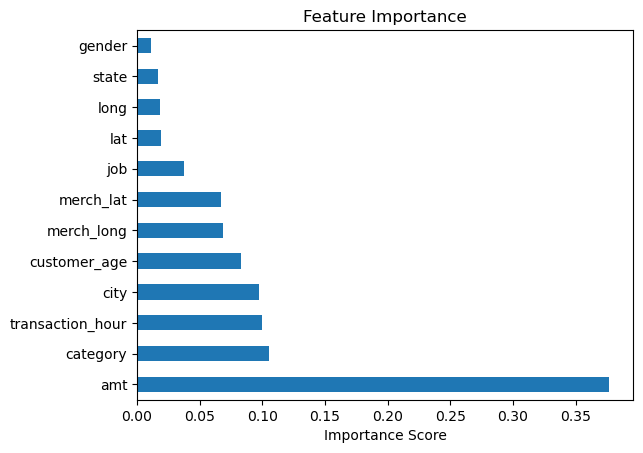

In [27]:
model = ExtraTreesClassifier(n_jobs=-1).fit(X,y)
feature_imp = pd.Series(model.feature_importances_, index=X.columns)
feature_imp.nlargest(20).plot(kind='barh')
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.show()

It seems amount, transaction hour, category and city, age are most important in classifying the fraud than other features. This plot will help us figure out what features we can use to train the model.

<Axes: >

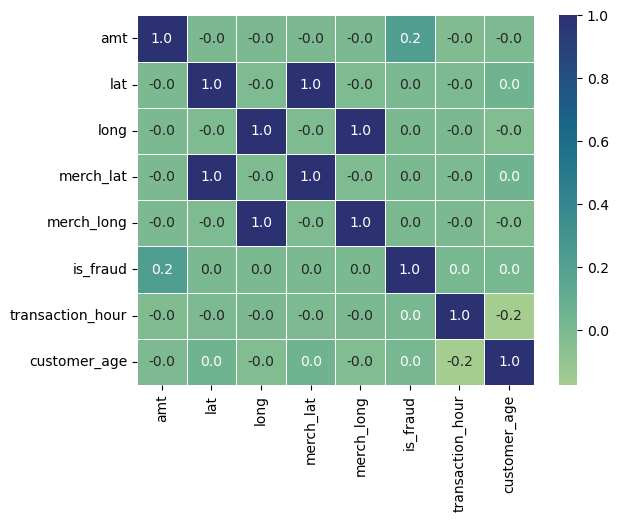

In [28]:
sns.heatmap(cleaned_up_df.corr(),annot=True,fmt='.1f',linewidth=.5,cmap="crest")

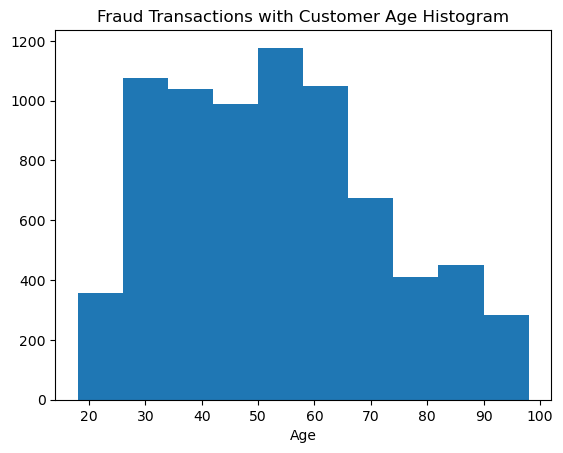

In [29]:
#create a fraud only dataset and understand how age impacts
fr_df = cleaned_up_df.query('is_fraud == 1')
plt.title('Fraud Transactions with Customer Age Histogram')
plt.hist(fr_df['customer_age'])
plt.xlabel('Age')
plt.show()

The above histogram shows that 30-60 years age people are victims of fraud transactions than other age people.

#### Scale Features

In [30]:
# used StandardScaler to scale the features.
X = StandardScaler().fit_transform(X)

### Classification Model Building
Lets build some of the classification models and evaluate performance of them. Here are the models im considering for this use case
* LogisticRegression
* KNN
* DecisionTreeClassifier
* SVM
* GaussianNB
* SGDClassifier

#### Split the data

In [31]:
# split the dataset with test set size of 30%  of the dataset.
X_train,X_test,y_train,y_test =  train_test_split(X,y,test_size=0.3,random_state=42)

#### Helper methods and data structures

In [32]:
# function to plot the confusion matrix
def plot_confusion_matrix(y_test,classifier,X_test,title): 
    cm = confusion_matrix(y_test,classifier.predict(X_test))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classifier.classes_)
    disp.plot()
    disp.ax_.set_title(title)


# build a method to tune hyper parameters of various models using GridSearchCV
def hyper_parameter_tuning(model,grid_params):
    gs = GridSearchCV(model,param_grid=grid_params, scoring="accuracy", cv=5,n_jobs=-1).fit(X_train,y_train)
    return gs

# dictionary to track each model's accuracy and scores.
model_test_scores = {}
balanced_accuracy_scores_dict = {}
precision_dict = {}
recall_dict = {}
f1_score_dict = {}



# track scores
def measure_scores(clf,X_test,y_test,model_name):
    y_preds = clf.predict(X_test)
    balanced_accuracy_scores_dict[model_name] = balanced_accuracy_score(y_test,y_preds)
    precision,recall,f1,support = precision_recall_fscore_support(y_test,y_preds,average='binary')
    precision_dict[model_name] = precision
    recall_dict[model_name] = recall
    f1_score_dict[model_name] = f1
    model_test_scores[model_name]=clf.score(X_test,y_test)

#### Base Models
Lets look at LogisticRegression,KNN and SGDClassifier with default hyper parameters and see how these models perform on this dataset.

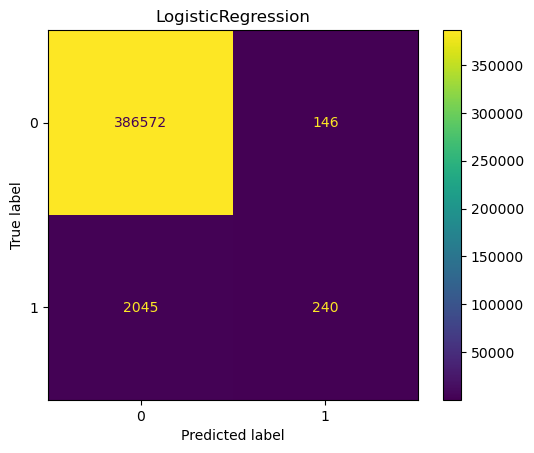

In [33]:
lgr = LogisticRegression().fit(X_train,y_train)
plot_confusion_matrix(y_test,lgr,X_test,'LogisticRegression')

#measure performance
measure_scores(lgr,X_test,y_test,'LogisticRegression')

In [34]:
f1_score_dict['LogisticRegression']

0.17970797454137027

Trained the base **LogisticRegression** using default hyper parameters and the above confusion matrix shows the accuracy of prediction of the fraud transactions.

It shows that  this model predicts only **True Negatives** but not **True Positives**. The **f1_score** of the model is only 17% which is not so great so technically  we cannot use this model as it will say every transaction is not a fraud one.


#### Hyper Parameter Tuning

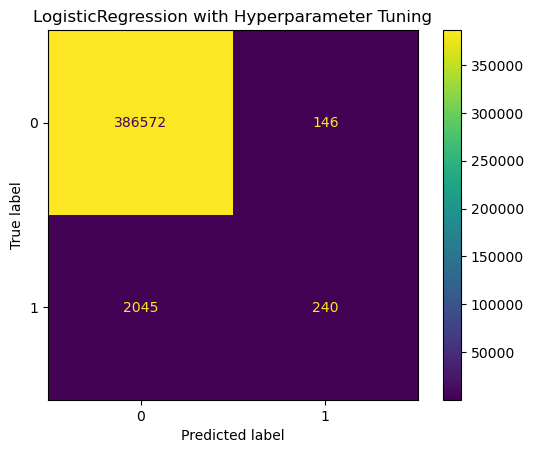

In [35]:
params = {
    'C':[0.1,0.5,1.0],
    'max_iter':[5000,10000]
}
lgr = LogisticRegression(n_jobs=-1)
gs = GridSearchCV(lgr,param_grid=params).fit(X_train,y_train)
plot_confusion_matrix(y_test,gs,X_test,'LogisticRegression with Hyperparameter Tuning')
measure_scores(gs,X_test,y_test,'LogisticRegression_GridSearch')

In [36]:
f1_score_dict['LogisticRegression_GridSearch']

0.17970797454137027

Even after tuning hyper parameters of the LogisticRegression the model didnt improved much. Lets evaluate other models and see.

#### KNN

KNeighborsClassifier(n_jobs=-1, n_neighbors=3)


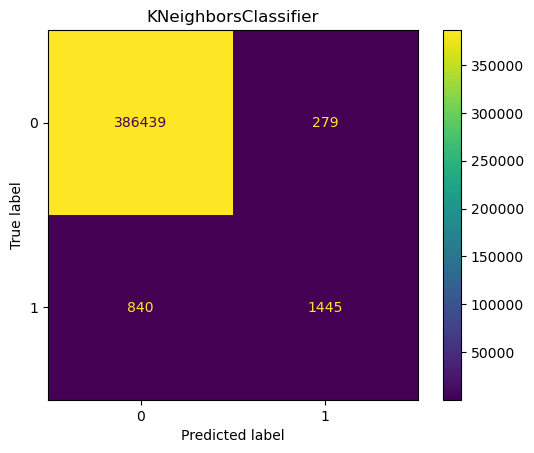

In [37]:
knn_m = KNeighborsClassifier(n_jobs=-1)
params = {
    "n_neighbors": np.array(range(1,5))
}
knn_gs = hyper_parameter_tuning(knn_m,params)
print(knn_gs.best_estimator_)
plot_confusion_matrix(y_test,knn_gs,X_test,'KNeighborsClassifier')
measure_scores(knn_gs,X_test,y_test,'KNeighborsClassifier')

In [38]:
print(f1_score_dict['KNeighborsClassifier'],balanced_accuracy_scores_dict['KNeighborsClassifier'])

0.7208780244449987 0.8158318322027338


KNN improved much with n_neighbors of 3, the f1_score is 72% and the balanced accuracy score is 81.5%.

##### DecisionTreeClassifier

DecisionTreeClassifier(max_depth=12)


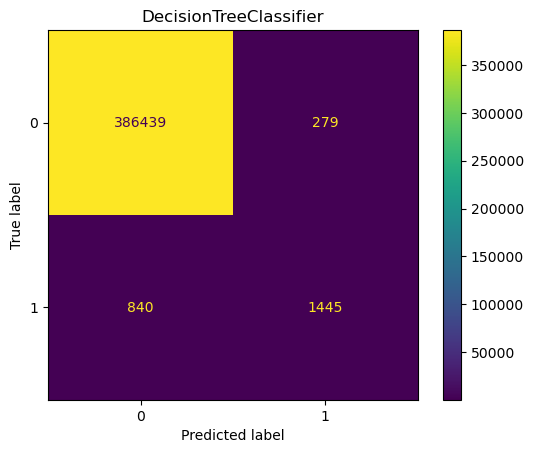

In [39]:
tree_m = DecisionTreeClassifier()
tree_parameter = {
"max_depth": np.array(range(1,15))
}
tree_gs = hyper_parameter_tuning(tree_m,tree_parameter)
print(tree_gs.best_estimator_)
plot_confusion_matrix(y_test,knn_gs,X_test,'DecisionTreeClassifier')
measure_scores(knn_gs,X_test,y_test,'DecisionTreeClassifier')

In [40]:
print(f1_score_dict['DecisionTreeClassifier'],balanced_accuracy_scores_dict['DecisionTreeClassifier'])

0.7208780244449987 0.8158318322027338


DecisionTreeClassifier with max depth of 12 is performing at 72% of f1_score and balanced accuracy is 81.5% which is close to KNN but is not reaching our goal.

##### SVM(LinearSVC)

LinearSVC(C=0.1)


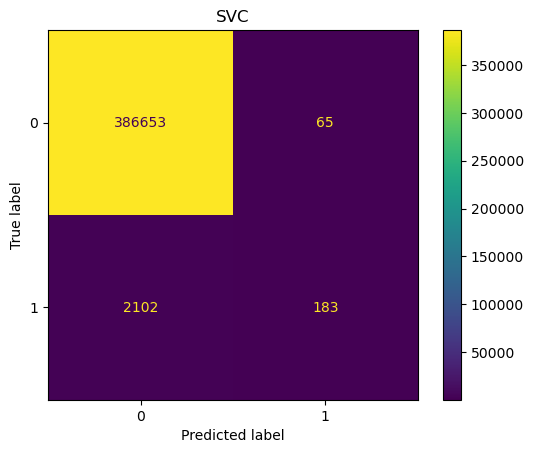

In [41]:
lsvc = LinearSVC()
l_params = {
    'C':[0.1,1.0,10,100],
    'penalty':['l1', 'l2']
}
lsvc_gs = hyper_parameter_tuning(lsvc,l_params)
print(lsvc_gs.best_estimator_)
plot_confusion_matrix(y_test,lsvc_gs,X_test,'SVC')
measure_scores(lsvc_gs,X_test,y_test,'SVC')

In [42]:
print(f1_score_dict['SVC'],balanced_accuracy_scores_dict['SVC'])

0.14449269640742202 0.5399597231091207


LinearSVC model's f1_score is pretty low(14%) and its balanced score of the target classes are 53% which means *true positive* prediction is way off of the train/test data.

So this model wont predict any frauds and its not a useful model for the business.

##### GuassianNB

GaussianNB(var_smoothing=1.0)


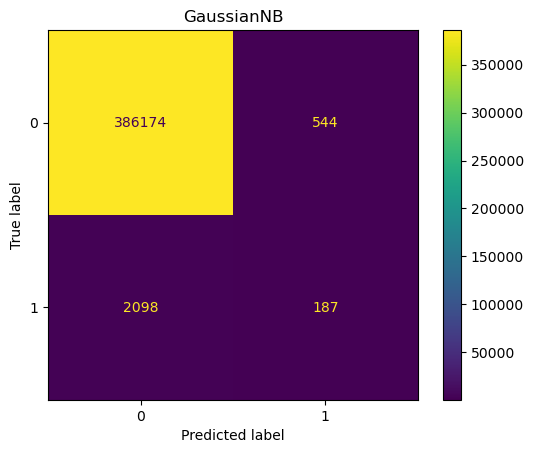

In [43]:
gnb = GaussianNB()
params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
gnb_gs = hyper_parameter_tuning(gnb,params_NB)
print(gnb_gs.best_estimator_)
plot_confusion_matrix(y_test,gnb_gs,X_test,'GaussianNB')
measure_scores(gnb_gs,X_test,y_test,'GaussianNB')

In [44]:
print(f1_score_dict['GaussianNB'],balanced_accuracy_scores_dict['GaussianNB'])

0.12400530503978781 0.540215682299689


GaussianNB model's fa score is 12% which is far less than basic LogisticRegression even after doing hyper parameter tuning. This model is not a great model for further analysis.

#### SGDClassifier

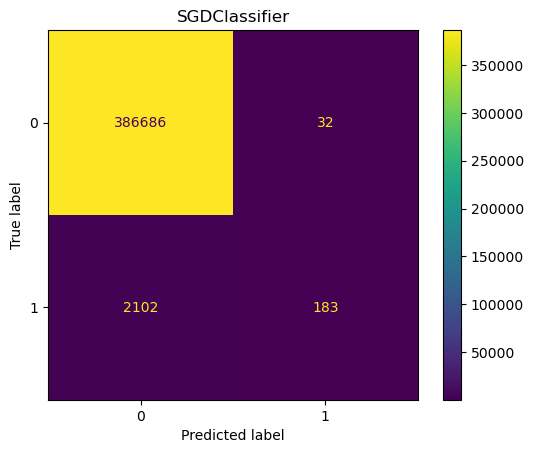

In [45]:
sgd = SGDClassifier()
s_params ={
    'alpha':[0.1,0.5,1],
    'penalty':['l1','l2','elasticnet'],
    'max_iter':[10000,15000,20000]
}
sgd_gs = hyper_parameter_tuning(sgd,s_params)
plot_confusion_matrix(y_test,sgd_gs,X_test,'SGDClassifier')
measure_scores(sgd_gs,X_test,y_test,'SGDClassifier')

In [46]:
print(f1_score_dict['SGDClassifier'],balanced_accuracy_scores_dict['SGDClassifier'])

0.1464 0.5400023898585349


SGDClassifier didnt performed very well as its f1_score is 14% only.

#### Performance

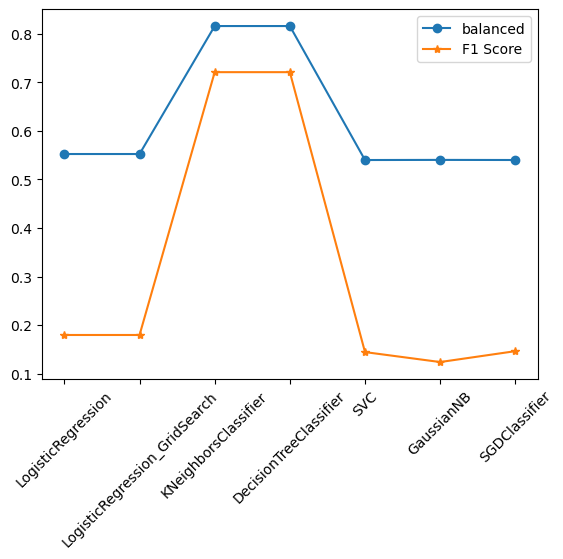

In [47]:
plt.plot(balanced_accuracy_scores_dict.keys(),balanced_accuracy_scores_dict.values(),label='balanced',marker='o')
plt.plot(f1_score_dict.keys(),f1_score_dict.values(),label='F1 Score',marker='*')
plt.xticks(rotation=45)
plt.legend()
plt.show()

The above plot shows the f1_score and the balanced score of various models. KNN and Decision Tree models are performing way better than other models.

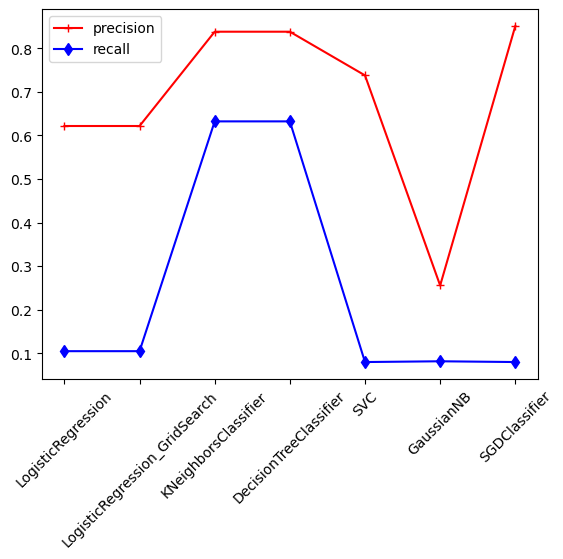

In [48]:
plt.plot(precision_dict.keys(),precision_dict.values(),label='precision',marker='+',color='r')
plt.plot(recall_dict.keys(),recall_dict.values(),label='recall',marker = 'd',color='b')
plt.xticks(rotation=45)
plt.legend()
plt.show()

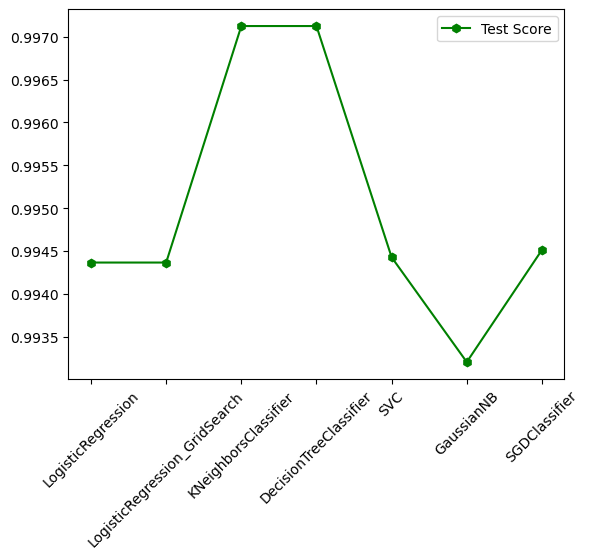

In [49]:
plt.plot(model_test_scores.keys(),model_test_scores.values(),label='Test Score',marker='h',color='g')
plt.xticks(rotation=45)
plt.legend()
plt.show()

The test score of various models shown here both KNN and Decision Tree test score is close to 100%.

#### Observations
Here are few points to note why they didn't performed well.
* The target classes imbalance.
* No hyper parameter tuning on all models.

### Balancing Target Classes

In this dataset there are only 1% of fraud transactions which made this models to not classify accurately  on the true positive records. There are some techniques we can use to balance this imbalance dataset. They are 
* Random Over Sampling
* BorderlineSMOTE
* SMOTE
* ADASYN

In [50]:
# A function to build a model using RandomForestClassifier with data using balancing techniques to evaluate the performance

def sampled_random_forest_performance(X_sampled,y_sampled,sample_algorithm):
    X_sampled_train,X_sampled_test,y_sampled_train,y_sampled_test = train_test_split(X_sampled,y_sampled,test_size=0.3,random_state=42)

    #train the model
    r_sampled = RandomForestClassifier(n_jobs=-1).fit(X_sampled_train,y_sampled_train)
    plot_confusion_matrix(y_sampled_test,r_sampled,X_sampled_test,'RandomForestClassifier_' + sample_algorithm)
    measure_scores(r_sampled,X_sampled_test,y_sampled_test,'RandomForestClassifier_' + sample_algorithm)    
    

#### RandomOverSampler

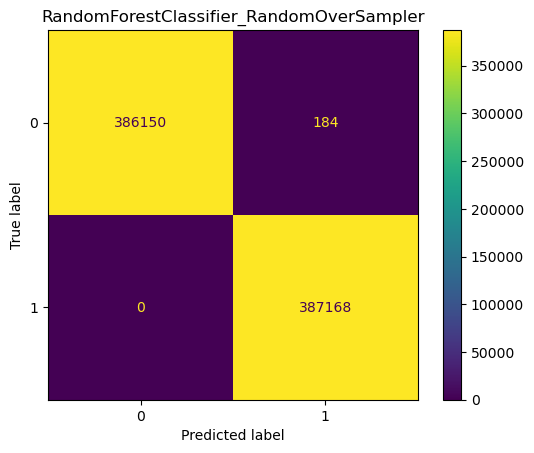

In [51]:
X_sampled,y_sampled = RandomOverSampler(random_state=42).fit_resample(X,y)
sampled_random_forest_performance(X_sampled,y_sampled,'RandomOverSampler')

RandomOverSampler model's *true positive* rate is 100% accuracy but the data is duplicated and this model is kind of over fitting with training dataset.

#### BorderlineSMOTE

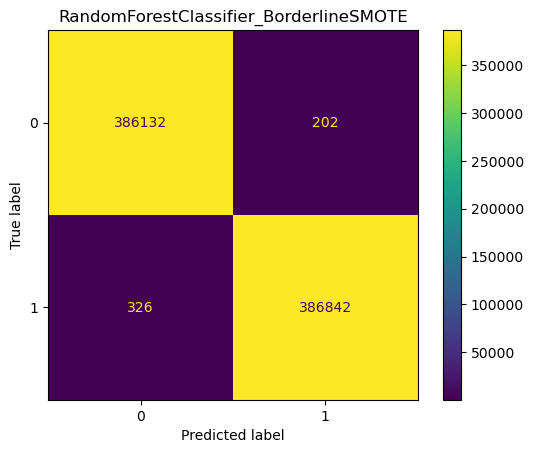

In [52]:
kms = BorderlineSMOTE(random_state=42)
X_km_sample,y_km_sample = kms.fit_resample(X,y)

sampled_random_forest_performance(X_km_sample,y_km_sample,'BorderlineSMOTE')

BorderlineSMOTE is also predicting close to 100% on *true positive* but lot of data duplication since the target classes are imbalanced.

#### SMOTE

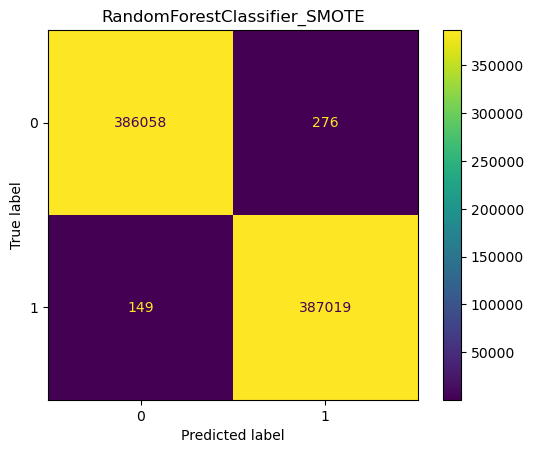

In [53]:
smote = SMOTE(random_state=42)
X_smote_sampled,y_smote_sampled = smote.fit_resample(X,y)
sampled_random_forest_performance(X_smote_sampled,y_smote_sampled,'SMOTE')

#### ADASYN

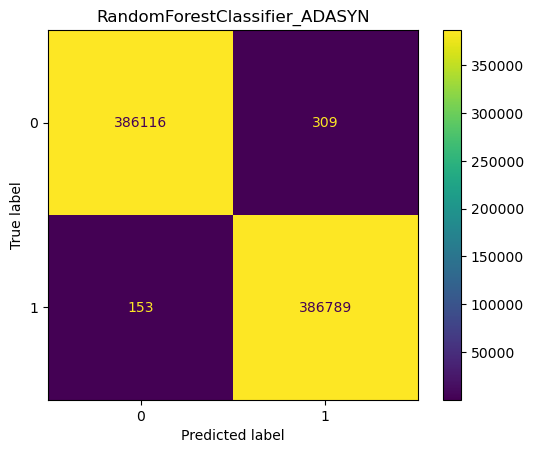

In [54]:
adasyn = ADASYN(random_state=42)
X_adasyn_sampled,y_adasyn_sampled = adasyn.fit_resample(X,y)
sampled_random_forest_performance(X_adasyn_sampled,y_adasyn_sampled,'ADASYN')

Both  SMOTE and ADASYN are also duplicating the training data and test data so predicting close to 100%

#### Sampling Observations

Over sampling of the imbalanced dataset technique is predicting *true positive* accurately but there is lot of data duplication since classes are imbalanced. These models seems overfit on the training data and may not predict accurately when these models try on unseen data.

### Ensemble Techniques
Using the following ensemble techniques to evaluate the models and find out the best model.

* BaggingClassifier
* AdaBoostClassifier
* BalancedRandomForestClassifier
* RUSBoostingClassifier
* RandomForestClassifier

#### BaggingClassifier

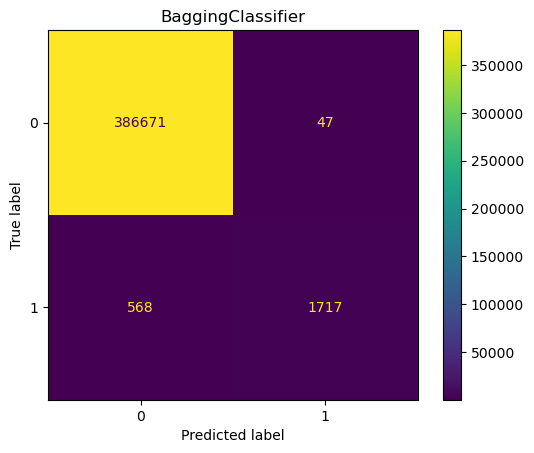

In [55]:
r_bc = RandomForestClassifier(n_jobs=-1)
bc = BaggingClassifier(base_estimator=r_bc,random_state=42).fit(X_train,y_train)
plot_confusion_matrix(y_test,bc,X_test,'BaggingClassifier')
measure_scores(bc,X_test,y_test,'BaggingClassifier')

In [241]:
print(balanced_accuracy_scores_dict['BaggingClassifier'])

0.8756503919427976


The balanced score of the BaggingClassifer model is 87% accuracy in predicting both *true positive* and *true negative* but still this model is almost 35% wrong in *true positive* prediction.

#### AdaBoostingClassifier

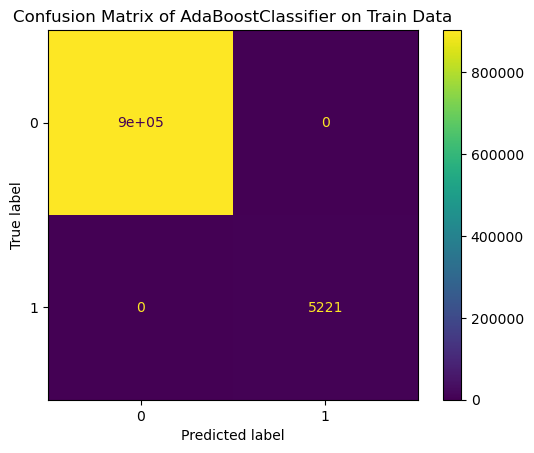

In [57]:
r = RandomForestClassifier(n_jobs=-1)
ada = AdaBoostClassifier(r).fit(X_train,y_train)
plot_confusion_matrix(y_train,ada,X_train,'Confusion Matrix of AdaBoostClassifier on Train Data')
measure_scores(ada,X_test,y_test,'AdaBoostClassifier')

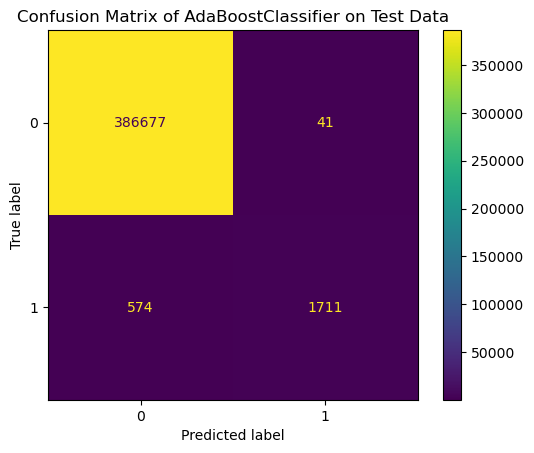

In [58]:
plot_confusion_matrix(y_test,ada,X_test,'Confusion Matrix of AdaBoostClassifier on Test Data')

In [245]:
print(balanced_accuracy_scores_dict['AdaBoostClassifier'],f1_score_dict['AdaBoostClassifier'])

0.8743452392491362 0.8476591528362646


AdaBoostClassifier's balanced score is close to 87% as well on the test data but its predicting 100% on train data.

#### BalancedRandomForestClassifier

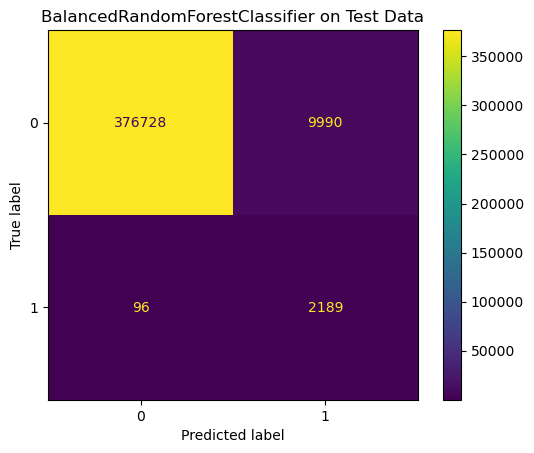

In [59]:
from imblearn.ensemble import BalancedRandomForestClassifier
brfc = BalancedRandomForestClassifier(n_estimators=100, random_state=0, sampling_strategy="all", replacement=True,n_jobs=-1).fit(X_train,y_train)
plot_confusion_matrix(y_test,brfc,X_test,'BalancedRandomForestClassifier on Test Data')
measure_scores(brfc,X_test,y_test,'BalancedRandomForestClassifier')

In [246]:
print(balanced_accuracy_scores_dict['BalancedRandomForestClassifier'], f1_score_dict['BalancedRandomForestClassifier'])

0.9660770467622481 0.30268252212389385


BalancedRandomForestClassifier is predicting *true positive* score of 96% which is performing way better than many models.

#### RUSBoostingClassifier

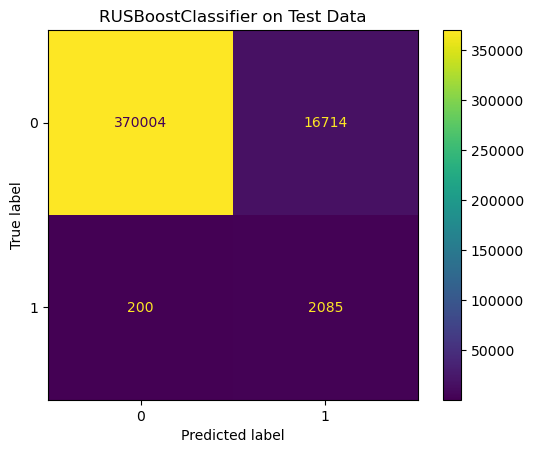

In [60]:
from imblearn.ensemble import RUSBoostClassifier
rusboost = RUSBoostClassifier(n_estimators=200, algorithm='SAMME.R',
                              random_state=0).fit(X_train,y_train)
plot_confusion_matrix(y_test,rusboost,X_test,'RUSBoostClassifier on Test Data')
measure_scores(rusboost,X_test,y_test,'RUSBoostClassifier')

In [247]:
print(balanced_accuracy_scores_dict['RUSBoostClassifier'])

0.9346262617387597


RSUBoostClassifier is also predicting accurately on the *true positive* of 93%.

#### RandomForestClassifier

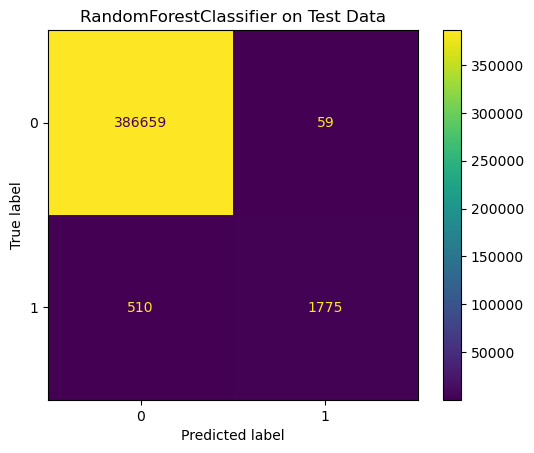

In [62]:
rfc = RandomForestClassifier(n_jobs=-1).fit(X_train,y_train)
plot_confusion_matrix(y_test,rfc,X_test,'RandomForestClassifier on Test Data')
measure_scores(rfc,X_test,y_test,'RandomForestClassifier')

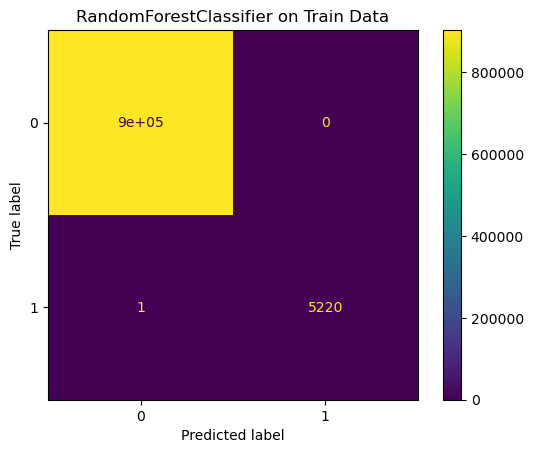

In [63]:
plot_confusion_matrix(y_train,rfc,X_train,'RandomForestClassifier on Train Data')

RandomForestClassifier model score is close to 70%  on true positive on test data but is predicting close to 100% on train data which seem overfitting.

#### Ensemble Models Observations

Most of the ensemble model's are performing better than standard,over sampled models. **BalancedRandomForestClassifier** is the most accurately predicted model and can be used in production use cases after further evaluations.

### Deep Learning
Lets build few deep learning models using *keras* to see how it performs on the imbalanced dataset.

#### Base Neural Network
Creating a base neural net with 2 hidden Dense layers and an output layer, train the model using 25 epocs with cross entropy and **adam** optimizer.

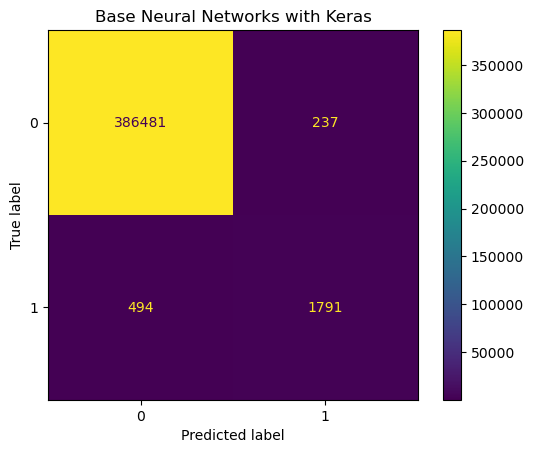

In [231]:
# create model

model = Sequential()
model.add(InputLayer(input_shape=(X_train.shape[1],)))
model.add(Dense(60, activation='relu'))
model.add(Dense(30,activation='relu'))
model.add(Dense(1, activation='sigmoid'))

 # Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#evaluate the model
m_history  = model.fit(X_train,y_train,epochs=75,batch_size=256,validation_split=0.2,verbose=False)

#plot the confusion matrix
y_preds = np.round(model.predict(X_test,verbose=False))
cm = confusion_matrix(y_test,y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1])
disp.plot()
disp.ax_.set_title('Base Neural Networks with Keras')
plt.show()


Deep learning standard models with 2 hidden layers and trined with 75 epochs achieved true positive score of 75% only which is very less than the ensemble models performance.

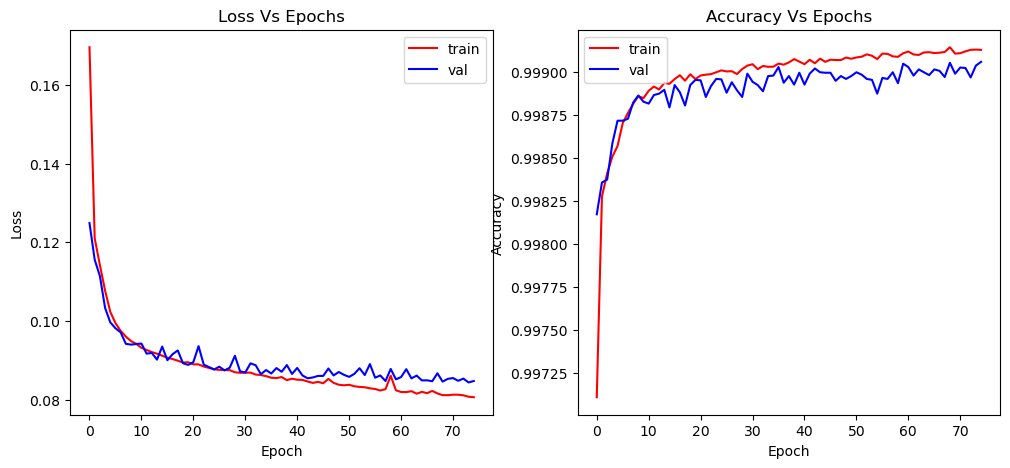

In [233]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12, 5))
# Plot the loss function
ax1.plot(np.sqrt(m_history.history['loss']), 'r', label='train')
ax1.plot(np.sqrt(m_history.history['val_loss']), 'b' ,label='val')
ax1.set_xlabel(r'Epoch')
ax1.set_ylabel(r'Loss')
ax1.set_title('Loss Vs Epochs')
ax1.legend()

# Plot the accuracy
ax2.plot(np.sqrt(m_history.history['accuracy']), 'r', label='train')
ax2.plot(np.sqrt(m_history.history['val_accuracy']), 'b' ,label='val')
ax2.set_xlabel(r'Epoch')
ax2.set_ylabel(r'Accuracy')
ax2.set_title('Accuracy Vs Epochs')
ax2.legend()


In [234]:
# measure the performance
balanced_accuracy_scores_dict['Neural Net'] = balanced_accuracy_score(y_test,y_preds)
precision,recall,f1,support = precision_recall_fscore_support(y_test,y_preds,average='binary')
precision_dict['Neural Net'] = precision
recall_dict['Neural Net'] = recall
f1_score_dict['Neural Net'] = f1
model_test_scores['Neural Net']=model.evaluate(X_test,y_test,verbose=False)

In [181]:
visualizer(model, file_format='png', view=True,file_name='images/base_deep_learning_graph')

#### Optimize Deep Learning Model
Lets optimize deep learning model using hyper parameter tuning with **RandomizedSearchCV**.

In [215]:
def create_model():
    model = Sequential()
    model.add(Dense(64,input_shape=(X_train.shape[1],)))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32,activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(16,activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])
    return model  


# create the sklearn model for the network
model_init_batch_epoch_CV = KerasClassifier(build_fn=create_model, verbose=1)

# we choose the initializers that came at the top in our previous cross-validation!!
batches = [5000, 10000,15000]
epochs = [25,50,75]

param_grid = dict(epochs=epochs, batch_size=batches)

# train the model with RandomizedSearchCV
grid = RandomizedSearchCV(estimator=model_init_batch_epoch_CV, 
                    param_distributions=param_grid,
                    cv=5,n_jobs=-1,random_state=42).fit(X_train,y_train)



2023-12-26 08:08:03.168764: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-26 08:08:03.186994: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-26 08:08:03.196820: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-26 08:08:03.511817: I tensorflow/core/platform/cpu_featu

Epoch 1/25
Epoch 1/50
Epoch 1/25
Epoch 1/25
Epoch 1/25
Epoch 1/25
Epoch 1/75
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/75
139/146 [===========================>..] - ETA: 0s - loss: 0.0835 - accuracy: 0.9897Epoch 2/25
Epoch 2/50
144/146 [============================>.] - ETA: 0s - loss: 0.1652 - accuracy: 0.9486Epoch 2/50
Epoch 2/50
  4/146 [..............................] - ETA: 2s - loss: 0.0216 - accuracy: 0.9954Epoch 2/50
Epoch 2/25
146/146 [==============================] - 10s 46ms/step - loss: 0.0807 - accuracy: 0.9900
Epoch 2/75
146/146 [==============================] - 7s 47ms/step - loss: 0.0214 - accuracy: 0.9954..........] - ETA: 26s - loss: 0.0300 - accuracy: 0.99racy: 0.9......................] - ETA: 5s - loss: 0.0244 - accuracy: 0.99cy: 0.===>..............] - ETA: 3s - loss: 0.0237 - accuracy: 0.990.9=======>........] - ETA: 1s - loss: 0.0209 - accuracy: 0.999==========>...] - ETA: 0s - loss: 0.0211 - accuracy: 0.99
Epoch 3/50
146/146 [=======================

2023-12-26 08:31:02.429844: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


49/49 [==============================] - 8s 171ms/step - loss: 0.0161 - accuracy: 0.9962
Epoch 14/50
73/73 [==============================] - 8s 116ms/step - loss: 0.0113 - accuracy: 0.9969
Epoch 47/75
49/49 [==============================] - 8s 166ms/step - loss: 0.0163 - accuracy: 0.9963uracy: 0.9
Epoch 15/50
49/49 [==============================] - 9s 178ms/step - loss: 0.0144 - accuracy: 0.9965
Epoch 28/50
73/73 [==============================] - 9s 129ms/step - loss: 0.0102 - accuracy: 0.9973
Epoch 72/75
49/49 [==============================] - 11s 220ms/step - loss: 0.0141 - accuracy: 0.9966acy: 0.9
Epoch 27/50
73/73 [==============================] - 11s 155ms/step - loss: 0.0108 - accuracy: 0.9971TA: 4s - loss: 0.0099 - accuracy: 0.99
Epoch 62/75
49/49 [==============================] - 9s 195ms/step - loss: 0.0188 - accuracy: 0.9958
Epoch 7/75
49/49 [==============================] - 8s 168ms/step - loss: 0.0152 - accuracy: 0.9964
Epoch 23/50
73/73 [===========================

2023-12-26 08:32:36.798019: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


73/73 [==============================] - 6s 85ms/step - loss: 0.0103 - accuracy: 0.9973
Epoch 61/75
49/49 [==============================] - 6s 128ms/step - loss: 0.0129 - accuracy: 0.9968
Epoch 41/50
49/49 [==============================] - 6s 127ms/step - loss: 0.0147 - accuracy: 0.9964
Epoch 20/75
73/73 [==============================] - 8s 106ms/step - loss: 0.0101 - accuracy: 0.9974============>........] - ETA: 1s - loss: 0.0133 - accuracy: 0.9
Epoch 64/75
49/49 [==============================] - 6s 128ms/step - loss: 0.0132 - accuracy: 0.9968- accuracy: 0.99
Epoch 43/50
49/49 [==============================] - 7s 147ms/step - loss: 0.0237 - accuracy: 0.9947- ETA: 3s - loss: 0.0103 - accuracy: 0.99
Epoch 4/75
49/49 [==============================] - 6s 125ms/step - loss: 0.0144 - accuracy: 0.9966===========>..........] - ETA: 2s - loss: 0.0141 - accuracy: 0.99
Epoch 30/50
49/49 [==============================] - 6s 127ms/step - loss: 0.0127 - accuracy: 0.99670.99
Epoch 42/50
73/73

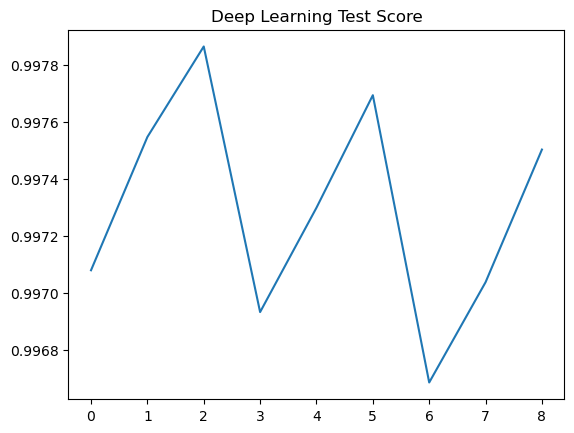

In [253]:
plt.plot(grid.cv_results_['mean_test_score'])
plt.title('Deep Learning Test Score')
plt.show()

78/78 [==============================] - 0s 3ms/step


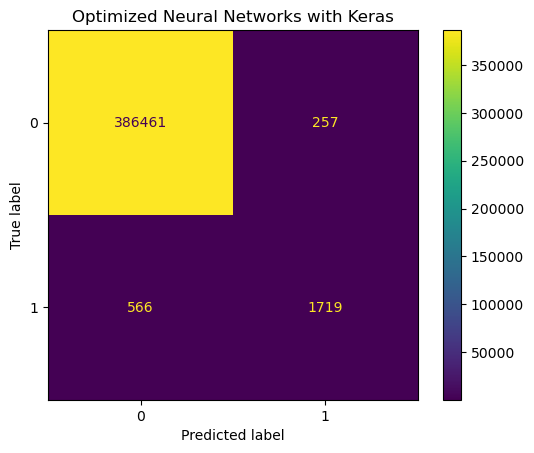

In [220]:
#plot the confusion matrix
y_preds = np.round(grid.predict(X_test))
cm = confusion_matrix(y_test,y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1])
disp.plot()
disp.ax_.set_title('Optimized Neural Networks with Keras')
plt.show()

Even after training the deep learning models using **RandomizedSearchCV** cross validation techniques with varying in epochs and batch size still the *true positive* prediction is very low compared to ensemble models.

In [221]:
# measure the performance
balanced_accuracy_scores_dict['Optimized Neural Net'] = balanced_accuracy_score(y_test,y_preds)
precision,recall,f1,support = precision_recall_fscore_support(y_test,y_preds,average='binary')
precision_dict['Optimized Neural Net'] = precision
recall_dict['Optimized Neural Net'] = recall
f1_score_dict['Optimized Neural Net'] = f1
model_test_scores['Optimized Neural Net']=model.evaluate(X_test,y_test,verbose=False)

In [227]:
visualizer(create_model(), file_format='png', view=True,file_name='images/optimized_deep_learning_graph')

#### Deep Learning Models Observations

After training standard deep learning models and also with RandomizedSearchCV to tune hyper parameters (epochs,batch size) still didnt achieve our goal of 90% accuracy in *true positive* prediction.

## Performance

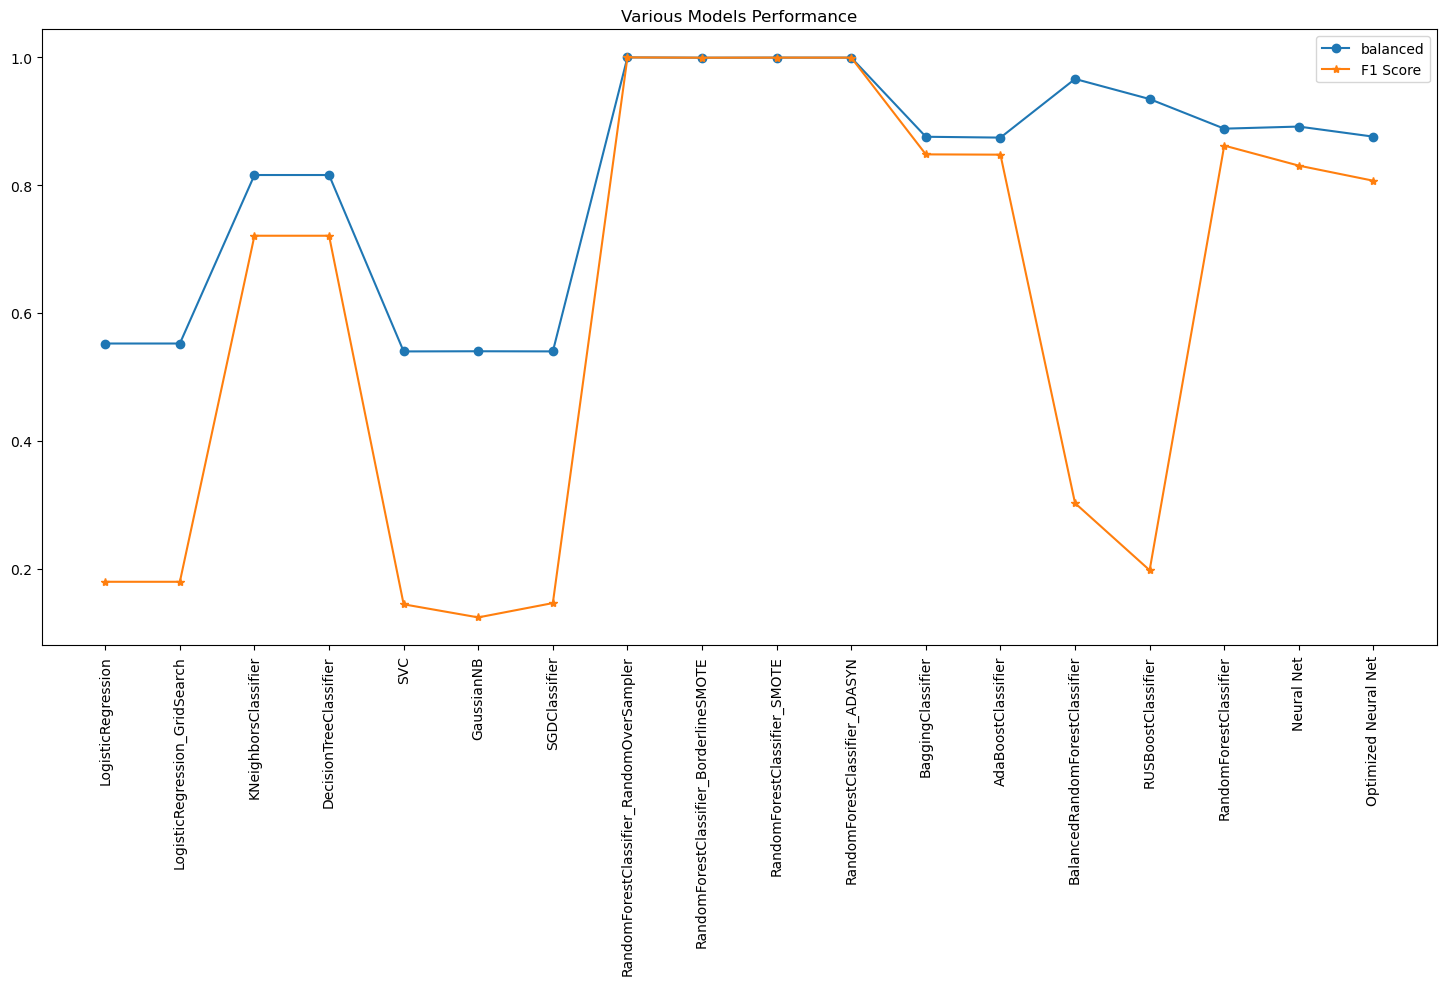

In [235]:
plt.figure(figsize=(18,8))
plt.plot(balanced_accuracy_scores_dict.keys(),balanced_accuracy_scores_dict.values(),label='balanced',marker='o')
plt.plot(f1_score_dict.keys(),f1_score_dict.values(),label='F1 Score',marker='*')
plt.xticks(rotation=90)
plt.title('Various Models Performance')
plt.legend()
plt.show()

The above plot shows the performance of various models balanced score and f1 score.

Here are some of the observations.

* Some of the over sampled models performed very well but they are overfitting because of lot of data duplication during over sampling technique.
* Basic classification models are not predicting accurately on the *true positive*.
* Ensemble models are performing beyond our goal of 90% accuracy in *true positive* prediction.
* Deep learning models are also not predicting accurately on  *true positive*.


After these analysis i think we can use **BalancedRandomForestClassifier** as the production quality model for this data and can be deployed.

### Deployment

#### Production Pipeline
Lets build a production pipeline by taking the **BalancedRandomForestClassifier** as the final model since its performing very well in predicting *true positives*.

In [237]:
#load dataset
card_transaction_test_df = pd.read_csv('data/fraudTest.csv')
card_transaction_test_df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


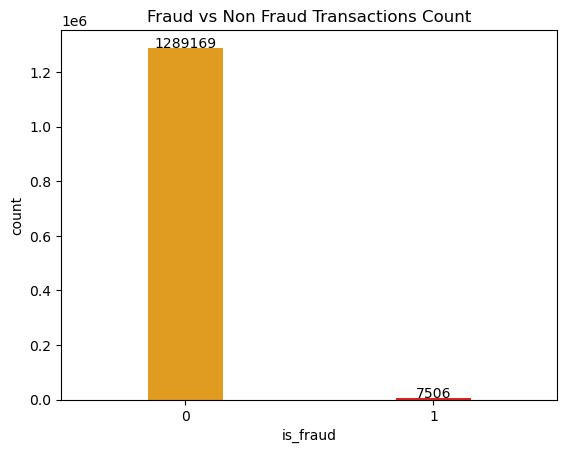

In [239]:
plot = sns.countplot(card_transaction_df,x='is_fraud',width=0.3,palette=['orange',"red"])
plot.text(0,len(card_transaction_df.query("is_fraud == 0")),len(card_transaction_df.query("is_fraud == 0")),horizontalalignment='center')
plot.text(1,len(card_transaction_df.query("is_fraud == 1")),len(card_transaction_df.query("is_fraud == 1")),horizontalalignment='center')
plt.title('Fraud vs Non Fraud Transactions Count')
plt.show()

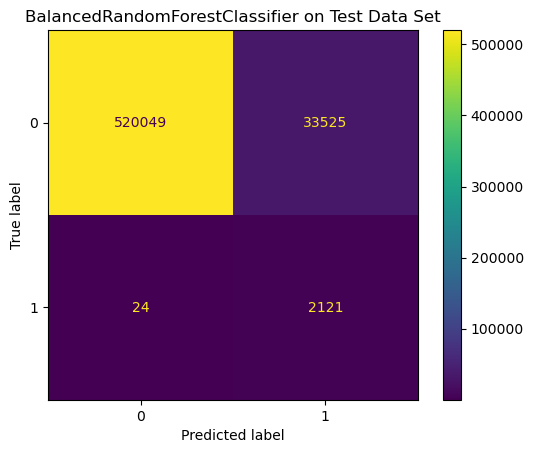

In [240]:
#load dataset
card_transaction_test_df = pd.read_csv('data/fraudTest.csv')
card_transaction_test_df.head()

card_transaction_test_df.drop(columns=['Unnamed: 0','cc_num','trans_num','first','last','merchant','zip','city_pop','street','unix_time'],axis=1,inplace=True)

# adding 'Hour' column as it might help in frauds as many frauds are happening overnight.
card_transaction_test_df['transaction_hour'] = pd.to_datetime(card_transaction_test_df['trans_date_trans_time'],format="%Y-%m-%d %H:%M:%S").dt.hour
#now we can drop 'trans_date_trans_time' column.
card_transaction_test_df.drop('trans_date_trans_time',axis=1,inplace=True)


current_year = datetime.date.today().year
card_transaction_test_df['customer_age'] = current_year - pd.to_datetime(card_transaction_test_df['dob']).dt.year
#drop the 'dob' column
card_transaction_test_df.drop('dob',axis=1,inplace=True)

X = card_transaction_test_df.drop('is_fraud',axis=1)
y = card_transaction_test_df['is_fraud']

#encoding
X = JamesSteinEncoder().fit_transform(X,y)

# used StandardScaler to scale the features.
X = StandardScaler().fit_transform(X)

plot_confusion_matrix(y,brfc,X,'BalancedRandomForestClassifier on Test Data Set')



The above prediction is on the test data set which this model never seen and using the using the **BalancedRandomForestClassifier** as our go to model for this use to predict *true positive*s and its score is more than 95% accuracy.

### Recommendations

Since these models are evaluated on the dataset available at the moment, to improve further accuracy these models needs to train real time on the daily  activity date and keep fine tune based on the future data as well.